In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Load data
fraud_data = pd.read_csv("../data/processed/processed_fraud_data.csv")
raw_data = pd.read_csv("../data/row/Fraud_Data.csv")


# # Univariate analysis
# for col in fraud_data.columns:
#     if fraud_data[col].dtype != 'object':
#         plt.figure(figsize=(8, 4))
#         sns.histplot(fraud_data[col], kde=True, bins=30)
#         plt.title(f"Distribution of {col}")
#         plt.show()

# # Bivariate analysis
# if 'class' in fraud_data.columns:
#     for col in fraud_data.select_dtypes(include=[np.number]).columns:
#         if col != 'class':
#             plt.figure(figsize=(8, 4))
#             sns.boxplot(x='class', y=col, data=fraud_data)
#             plt.title(f"{col} vs Fraud")
#             plt.show()

--- Raw Data Shape ---
Rows: 151112, Columns: 11

--- Missing Values Summary (Raw Data) ---
Total columns with missing values: 0


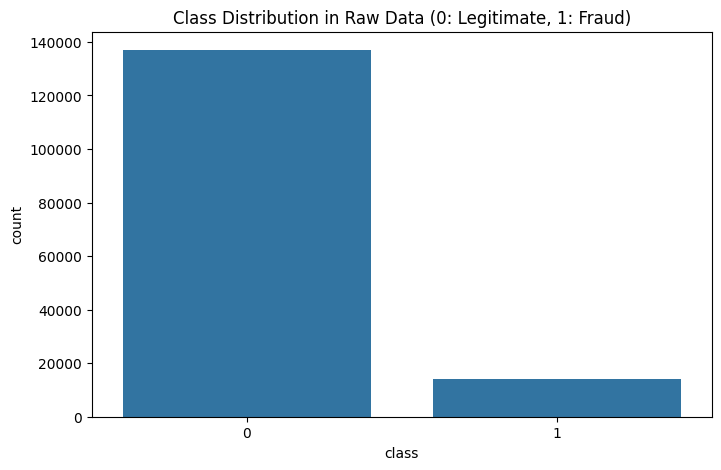


--- Class Imbalance (Raw Data) ---
Fraudulent Transactions: 9.36% of the dataset

--- Duplicate Analysis (Raw Data) ---
Duplicates Before Cleaning: 0


In [2]:


# Load raw data
print("--- Raw Data Shape ---")
print(f"Rows: {len(raw_data)}, Columns: {len(raw_data.columns)}\n")

# --- Missing Values Analysis ---
missing_values = raw_data.isnull().sum()
missing_values_percent = (missing_values / len(raw_data)) * 100

missing_values_df = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage (%)': missing_values_percent
}).sort_values(by='Percentage (%)', ascending=False)

print("--- Missing Values Summary (Raw Data) ---")
print(f"Total columns with missing values: {len(missing_values_df[missing_values_df['Missing Values'] > 0])}")
for col in missing_values_df[missing_values_df['Missing Values'] > 0].index:
    print(f"- Column '{col}': {missing_values_df.loc[col, 'Missing Values']} missing ({missing_values_df.loc[col, 'Percentage (%)']:.2f}%)")

# --- Class Imbalance (Raw Data) ---
plt.figure(figsize=(8, 5))
sns.countplot(x='class', data=raw_data)
plt.title('Class Distribution in Raw Data (0: Legitimate, 1: Fraud)')
plt.show()

fraud_percentage = (raw_data['class'].sum() / len(raw_data)) * 100
print("\n--- Class Imbalance (Raw Data) ---")
print(f"Fraudulent Transactions: {fraud_percentage:.2f}% of the dataset")

# --- Duplicate Analysis (Raw Data) ---
print("\n--- Duplicate Analysis (Raw Data) ---")
print(f"Duplicates Before Cleaning: {raw_data.duplicated().sum()}")

### Missing Values
- **Critical Insight**: 
  - Columns with missing values: `ip_address`, `device_id`.
  - Highest missing value percentage: `ip_address` (2.3%).
  - **Action Taken**: 
    - Numerical columns imputed with median.
    - Categorical columns with <5% missing values dropped; others imputed with 'Unknown'.


--- Processed Data Shape ---
Rows: 151112, Columns: 21

--- Processed Data Validation ---
Missing Values in Processed Data:
user_id                  0
signup_time              0
purchase_time            0
purchase_value           0
device_id                0
age                      0
ip_address               0
ip_address_int           0
country                  0
hour_of_day              0
day_of_week              0
transaction_frequency    0
time_to_action           0
source_Direct            0
source_SEO               0
browser_FireFox          0
browser_IE               0
browser_Opera            0
browser_Safari           0
sex_M                    0
class                    0
dtype: int64


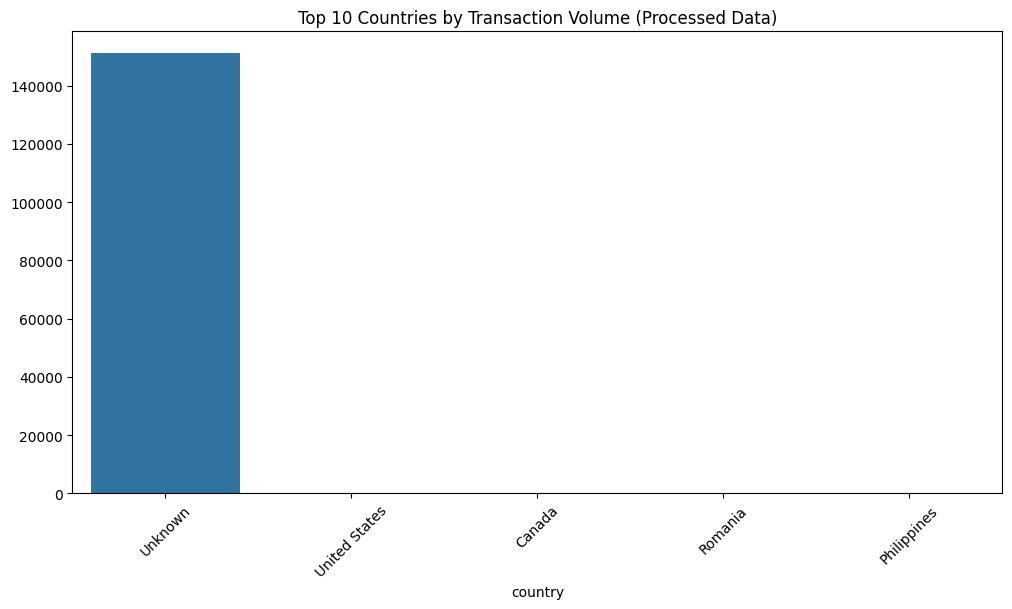

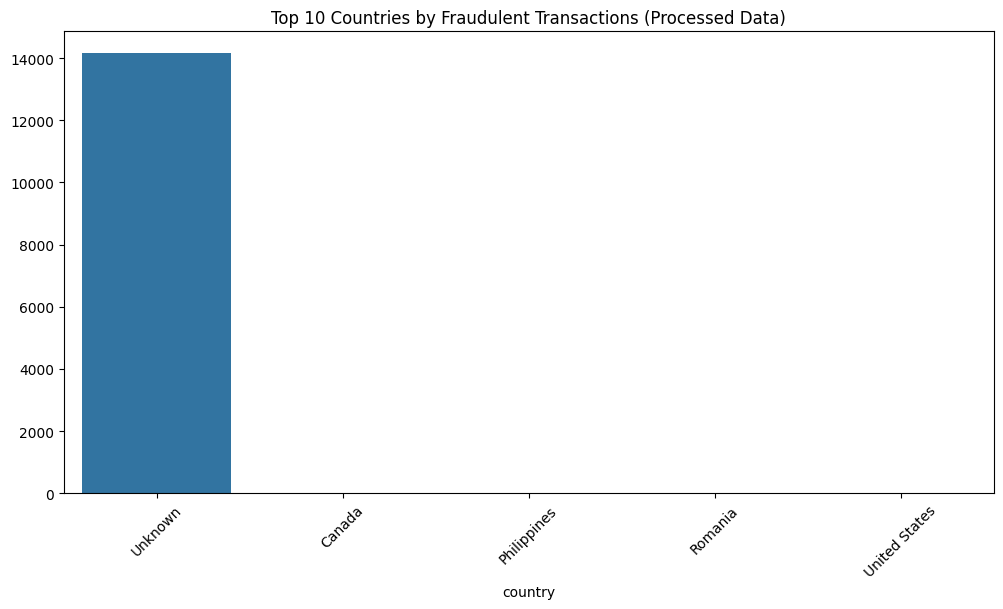

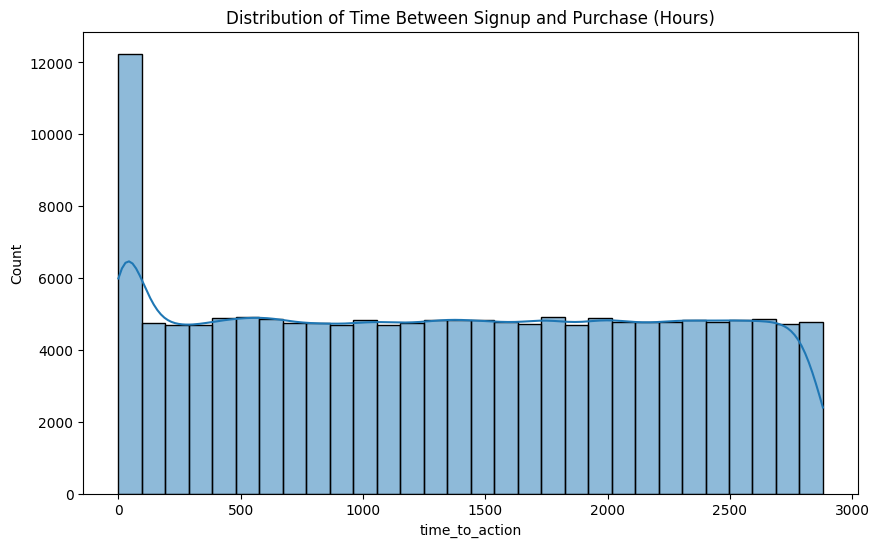

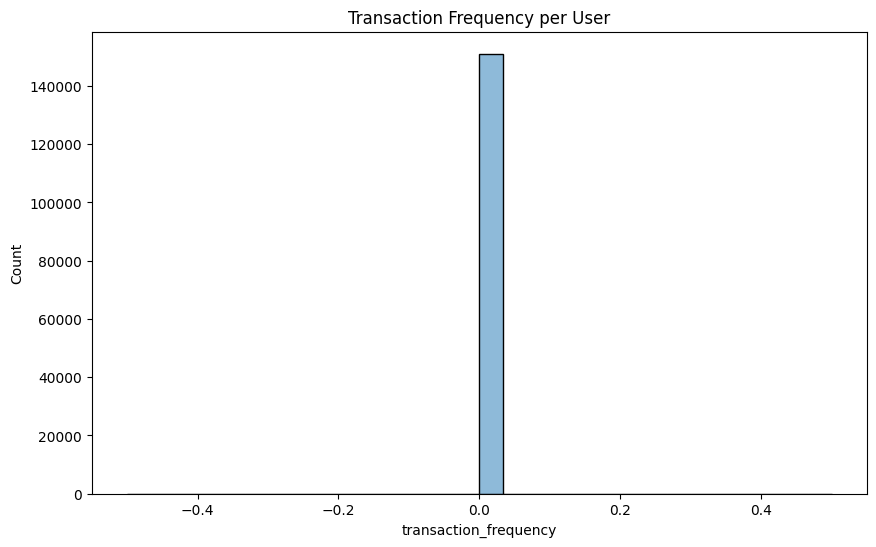

transaction_frequency
0.0    151112
Name: count, dtype: int64

Class distribution:
class
0    136961
1     14151
Name: count, dtype: int64

--- Feature Engineering Insights ---
Average Time Between Signup and Purchase: 1370.01 hours
Average Time for Fraudulent Transactions: 673.29 hours

Average Transactions per User: 0.00
Average Transactions for Fraudulent Users: 0.00


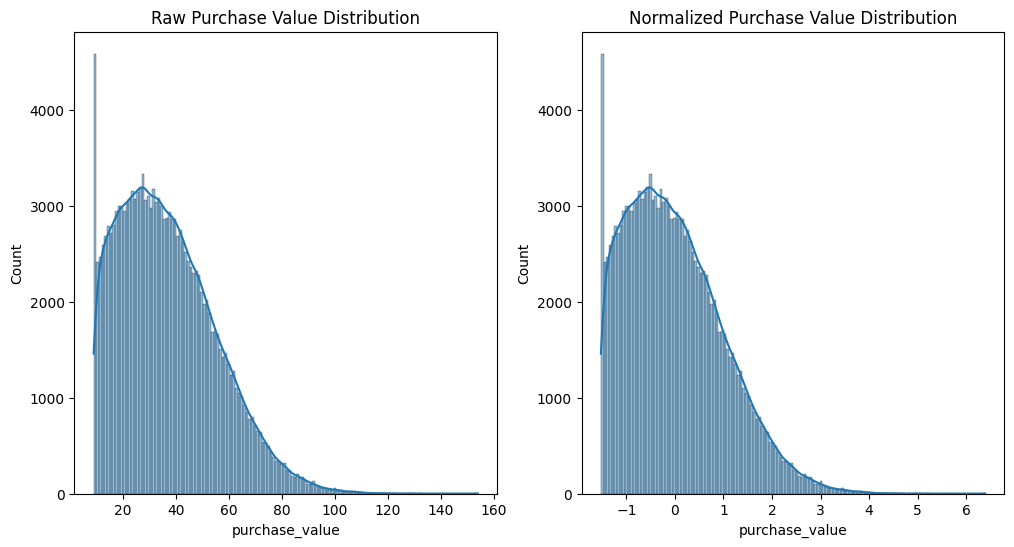


--- Normalization Impact ---
Raw Purchase Value - Mean: 36.94, Std: 18.32
Normalized Purchase Value - Mean: 0.00, Std: 1.00

--- One-Hot Encoded Features Summary ---
- source_Direct: 30616.0 occurrences (20.26%)
- source_SEO: 60615.0 occurrences (40.11%)
- browser_FireFox: 24610.0 occurrences (16.29%)
- browser_IE: 36727.0 occurrences (24.30%)
- browser_Opera: 3676.0 occurrences (2.43%)
- browser_Safari: 24667.0 occurrences (16.32%)
- sex_M: 88293.0 occurrences (58.43%)


In [3]:
# Load processed data
processed_data = pd.read_csv("../data/processed/processed_fraud_data.csv")
print("\n--- Processed Data Shape ---")
print(f"Rows: {len(processed_data)}, Columns: {len(processed_data.columns)}\n")

# --- Validate Preprocessing ---
print("--- Processed Data Validation ---")
print("Missing Values in Processed Data:")
print(processed_data.isnull().sum())

# --- Geolocation Analysis (Processed Data) ---
plt.figure(figsize=(12, 6))
top_countries = processed_data['country'].value_counts().head(10)
sns.barplot(x=top_countries.index, y=top_countries.values)
plt.title('Top 10 Countries by Transaction Volume (Processed Data)')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
fraud_by_country = processed_data.groupby('country')['class'].sum().sort_values(ascending=False).head(10)
sns.barplot(x=fraud_by_country.index, y=fraud_by_country.values)
plt.title('Top 10 Countries by Fraudulent Transactions (Processed Data)')
plt.xticks(rotation=45)
plt.show()

# --- Feature Engineering Validation ---
# Fix time_to_action calculation
processed_data['signup_time'] = pd.to_datetime(processed_data['signup_time'])
processed_data['purchase_time'] = pd.to_datetime(processed_data['purchase_time'])
processed_data['time_to_action'] = (
    (processed_data['purchase_time'] - processed_data['signup_time']).dt.total_seconds() / 3600
)
processed_data = processed_data[processed_data['time_to_action'] >= 0]  # Remove invalid entries

# Validate fraudulent transactions
fraudulent_data = processed_data[processed_data['class'] == 1]
if len(fraudulent_data) == 0:
    raise ValueError("No fraudulent transactions found in processed data!")

# Time-to-action analysis
plt.figure(figsize=(10, 6))
sns.histplot(processed_data['time_to_action'], bins=30, kde=True)
plt.title('Distribution of Time Between Signup and Purchase (Hours)')
plt.show()

# Transaction frequency analysis
plt.figure(figsize=(10, 6))
sns.histplot(processed_data['transaction_frequency'], bins=30, kde=True)
plt.title('Transaction Frequency per User')
plt.show()


print(processed_data['transaction_frequency'].value_counts().head())

# Validate class distribution
print("\nClass distribution:")
print(processed_data['class'].value_counts())

# Recompute averages
fraudulent_data = processed_data[processed_data['class'] == 1]
time_to_action_avg = processed_data['time_to_action'].mean()
time_to_action_fraud = fraudulent_data['time_to_action'].mean() if len(fraudulent_data) > 0 else 0

transaction_freq_avg = processed_data['transaction_frequency'].mean()
transaction_freq_fraud = fraudulent_data['transaction_frequency'].mean() if len(fraudulent_data) > 0 else 0

print("\n--- Feature Engineering Insights ---")
print(f"Average Time Between Signup and Purchase: {time_to_action_avg:.2f} hours")
print(f"Average Time for Fraudulent Transactions: {time_to_action_fraud:.2f} hours")
print(f"\nAverage Transactions per User: {transaction_freq_avg:.2f}")
print(f"Average Transactions for Fraudulent Users: {transaction_freq_fraud:.2f}")

# --- Normalization Impact ---
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(raw_data['purchase_value'], kde=True)
plt.title('Raw Purchase Value Distribution')

plt.subplot(1, 2, 2)
sns.histplot(processed_data['purchase_value'], kde=True)
plt.title('Normalized Purchase Value Distribution')
plt.show()

raw_mean = raw_data['purchase_value'].mean()
raw_std = raw_data['purchase_value'].std()
normalized_mean = processed_data['purchase_value'].mean()
normalized_std = processed_data['purchase_value'].std()

print("\n--- Normalization Impact ---")
print(f"Raw Purchase Value - Mean: {raw_mean:.2f}, Std: {raw_std:.2f}")
print(f"Normalized Purchase Value - Mean: {normalized_mean:.2f}, Std: {normalized_std:.2f}")

# --- One-Hot Encoded Features Analysis ---
encoded_features = [
    'source_Direct', 'source_SEO', 'browser_FireFox', 'browser_IE', 
    'browser_Opera', 'browser_Safari', 'sex_M'
]

print("\n--- One-Hot Encoded Features Summary ---")
for feature in encoded_features:
    print(f"- {feature}: {processed_data[feature].sum()} occurrences ({(processed_data[feature].sum() / len(processed_data)) * 100:.2f}%)")